<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/27_default_huggingface_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying German News Articles with HuggingFace Transformers

Inspired by
 * HuggingFace Tutorial - [Fine Tuning a pretrained model](https://huggingface.co/course/chapter3)
 * https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb

## Steps

1. Download 10kGNAD dataset
2. Create `DatasetDict` for *train* and *test* data
3. Load Tokenizer
4. Tokenize dataset
5. Define Training Parameters
6. Create Model
7. Train Model
8. Evaluate Model

## Prerequisites

In [35]:
checkpoint = "distilbert-base-german-cased"

# checkpoint = "deepset/gbert-base"

# checkpoint = "deepset/gelectra-base"

project_name = "10kgnad_huggingface__" + checkpoint.replace("/", "_")

In [36]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Nov 27 11:17:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    37W / 250W |  15149MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Connect Google Drive

In [37]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Install Packages

In [38]:
%%time
!pip install -q --upgrade tqdm transformers datasets >/dev/null
!pip install -q --upgrade optuna >/dev/null

# check installed version
!pip freeze | grep transformers
!pip freeze | grep torch
# transformers==4.12.5
# torch==1.10.0+cu111

transformers==4.12.5
torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu111/torchaudio-0.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchsummary==1.5.1
torchtext==0.11.0
torchvision @ https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp37-cp37m-linux_x86_64.whl
CPU times: user 118 ms, sys: 179 ms, total: 297 ms
Wall time: 10.8 s


In [39]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from transformers import logging
import optuna

# hide progress bar when downloading tokenizers (a workaround!)
logging.get_verbosity = lambda : logging.NOTSET

# disable transformer warnings like "Some weights of the model checkpoint ..."
logging.set_verbosity_error()

# disable logging of wandb
# os.environ["WANDB_SILENT"] = "true"

## Configure Weights & Biases

https://docs.wandb.ai/guides/integrations/huggingface

In [40]:
# !pip install -q -U wandb >/dev/null

# import wandb
# wandb.login()

# # "Make sure you set the project name before you initialize the Trainer!"
# # (default: huggingface)
# %env WANDB_PROJECT=vanilla_huggingface

# # Silence the output printed by wandb (false by default)
# %env WANDB_SILENT=true

## Fetch Data

Download [10k German News Articles Dataset](https://tblock.github.io/10kGNAD/)

In [41]:
%env DIR=data

!mkdir -p $DIR
!wget -nc https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O $DIR/train.csv
!wget -nc https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O $DIR/test.csv
!ls -lAh $DIR | cut -d " " -f 5-

env: DIR=data

2.7M Nov 27 10:37 test.csv
 24M Nov 27 10:37 train.csv


## Import Data

Using huggingface's [Dataset](https://huggingface.co/docs/datasets/loading.html#local-and-remote-files) implementation.

In [42]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset("csv",
                       data_files={"train": os.getenv("DIR")+"/train.csv",
                                   "test": os.getenv("DIR")+"/test.csv"},
                       sep=";", quotechar="'", names=["labels", "text"]
                       )

print(dataset)
display(dataset['train'].to_pandas().head())

Using custom data configuration default-a6533c8943292b91
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-a6533c8943292b91/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 9245
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 1028
    })
})


,labels,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


## Data Insights

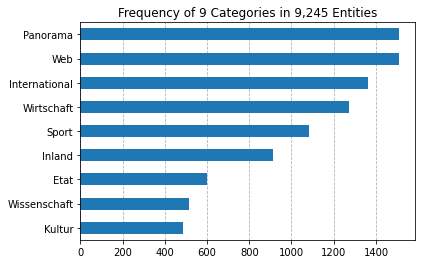

In [43]:
import matplotlib.pyplot as plt

def plot_categories(s: pd.Series):
    cat = s.value_counts(ascending=True)
    cat.plot.barh(title=f"Frequency of {len(cat)} Categories in {len(s):,} Entities", zorder=2)
    plt.gca().grid(axis='x', linestyle='--', zorder=1)

plot_categories(dataset['train'].to_pandas().labels)

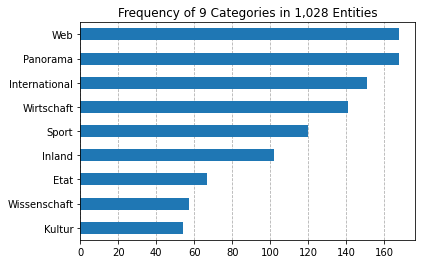

In [44]:
plot_categories(dataset['test'].to_pandas().labels)

## Data Preparation

There are a few requiremenf for feeding training data into SimpleTransformers:

* columns should be labeled `labels` and `text` (already done when reading the data)
* labels must be encoded as int values (starting at `0`!)

Additionally, we can handle imbalanced datasets by

* computing class weights for training

### Label Encoding

In [45]:
dataset["train"]

Dataset({
    features: ['labels', 'text'],
    num_rows: 9245
})

In [46]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(ds: DatasetDict):
    le = LabelEncoder()
    le.fit(ds['train']['labels'])

    def encode(data):
        return {'labels': le.transform(data['labels'])}

    return dataset.map(encode, batched=True), le

encoded_ds, le = encode_labels(dataset)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-a6533c8943292b91/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-c63a8fb4119a0db3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-a6533c8943292b91/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-c3aa185f41cce3a2.arrow


### Tokenization

In [47]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(data):
    # return tokenizer(data['text'], truncation=True, padding=True)
    return tokenizer(data['text'], padding='max_length', truncation=True)


tokenized_ds = encoded_ds.map(tokenize, batched=True).remove_columns('text')

print(tokenized_ds)
display(tokenized_ds['train'].to_pandas().head())

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-a6533c8943292b91/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-ded0520f6d1e5b7e.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 9245
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 1028
    })
})


,attention_mask,input_ids,labels
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[102, 1735, 232, 19231, 693, 5844, 2134, 378, ...",5
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[102, 11806, 646, 30881, 4195, 205, 13165, 818...",3
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[102, 351, 13236, 124, 7847, 123, 26074, 12309...",6
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[102, 16679, 853, 224, 12205, 818, 377, 268, 5...",7
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[102, 18600, 2671, 190, 13458, 13239, 30882, 5...",1


### Apply Padding per batch (only for GPU)

TPU does not like dynamic padding

In [48]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [49]:
# batch = data_collator(samples)
# {k: v.shape for k, v in batch.items()}

## Model

In [50]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    return {
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro'),
        }

# define training args
training_args = TrainingArguments(
    output_dir=project_name,
    # logging_dir=f"{args.output_data_dir}/logs",
    num_train_epochs=5,
    eval_steps=125,
    evaluation_strategy="steps",
    #   evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    # report_to="wandb",  # enable logging to W&B
                                #   fp16=True,
                                  )

num_labels = len(set(dataset["train"]["labels"]))
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)


# create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['test'],
    tokenizer=tokenizer,
)

# train model
trainer.train()

***** Running training *****
  Num examples = 9245
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1445


Step,Training Loss,Validation Loss,Acc,F1,Precision,Recall
125,No log,0.507429,0.848249,0.845356,0.835591,0.861277
250,No log,0.403133,0.872568,0.871075,0.870458,0.874892
375,No log,0.383428,0.870623,0.863421,0.866347,0.864721
500,0.531800,0.385237,0.872568,0.866605,0.866946,0.871598
625,0.531800,0.392230,0.876459,0.867819,0.879068,0.861548
750,0.531800,0.392510,0.886187,0.886088,0.886230,0.887110
875,0.531800,0.379909,0.884241,0.881138,0.881804,0.882267
1000,0.172100,0.392271,0.892023,0.889289,0.889651,0.889105
1125,0.172100,0.397974,0.900778,0.899029,0.903370,0.895529
1250,0.172100,0.420451,0.897860,0.894567,0.895812,0.893847


***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
Saving model checkpoint to 10kgnad_huggingface__distilbert-base-german-cased/checkpoint-500
Configuration saved in 10kgnad_huggingface__distilbert-base-german-cased/checkpoint-500/config.json
Model weights saved in 10kgnad_huggingface__distilbert-base-german-cased/checkpoint-500/pytorch_model.bin
tokenizer config file saved in 10kgnad_huggingface__distilbert-base-german-cased/checkpoint-500/tokenizer_config.json
Special tokens file saved in 10kgnad_huggingface__distilbert-base-german-cased/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
***** Running Evaluation *****
  Num exa

TrainOutput(global_step=1445, training_loss=0.26395247964298024, metrics={'train_runtime': 1371.7876, 'train_samples_per_second': 33.697, 'train_steps_per_second': 1.053, 'total_flos': 6124069906099200.0, 'train_loss': 0.26395247964298024, 'epoch': 5.0})

## Model Evaluation

In [51]:
%%time
trainer.evaluate(eval_dataset=tokenized_ds["test"])

***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32


CPU times: user 9.86 s, sys: 69.3 ms, total: 9.93 s
Wall time: 9.88 s


{'epoch': 5.0,
 'eval_acc': 0.892023346303502,
 'eval_f1': 0.8892892756559285,
 'eval_loss': 0.3922712504863739,
 'eval_precision': 0.8896509736480726,
 'eval_recall': 0.8891048910645488,
 'eval_runtime': 9.8726,
 'eval_samples_per_second': 104.127,
 'eval_steps_per_second': 3.343}

In [52]:
prediction = trainer.predict(tokenized_ds["test"])
pred_s = pd.DataFrame(prediction.predictions).idxmax(axis=1)

***** Running Prediction *****
  Num examples = 1028
  Batch size = 32


### Confusion Matrix and Classification Report

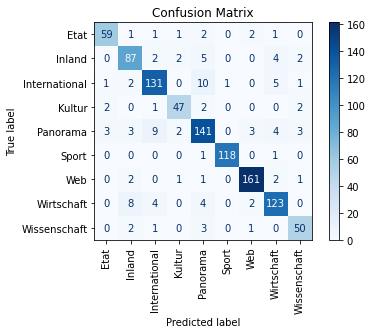

In [53]:
import sklearn.metrics as skm

test_labels = le.inverse_transform(tokenized_ds["test"]['labels'])
pred_labels = le.inverse_transform(pred_s)

cm = skm.confusion_matrix(test_labels, pred_labels, labels=le.classes_)
cmd = skm.ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cmd.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix");

In [54]:
print(skm.classification_report(test_labels, pred_labels))

               precision    recall  f1-score   support

         Etat       0.91      0.88      0.89        67
       Inland       0.83      0.85      0.84       102
International       0.88      0.87      0.87       151
       Kultur       0.89      0.87      0.88        54
     Panorama       0.83      0.84      0.84       168
        Sport       0.99      0.98      0.99       120
          Web       0.95      0.96      0.96       168
   Wirtschaft       0.88      0.87      0.88       141
 Wissenschaft       0.85      0.88      0.86        57

     accuracy                           0.89      1028
    macro avg       0.89      0.89      0.89      1028
 weighted avg       0.89      0.89      0.89      1028



---

## Hyperparameter Tuning

In [55]:
# from optuna.trial import Trial

# def model_init(trial: Trial):


#     if trial is not None:
#         # Initialize a new wandb run
#         #    wandb.init(project="vanilla_huggingface");
#         #    wandb.log(trial.params)

#         print(trial.datetime_start, trial.number)
#         print("trial dist", trial.distributions)
#         print("trial params", trial.params)

#     num_labels = len(set(gnad10k_ds["train"]["labels"]))
#     model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

#     # wandb.watch(model)

#     return model

In [56]:
# wandb.finish()

## Hyperparameter Tuning

In [57]:
# def my_hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 3),
#         # "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32, 64]),
#     }

# def my_objective(metrics):
#     # Your elaborate computation here
#     return result_to_optimize

In [58]:
# db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
# db_name = "vanilla_huggingface"
# print(db_path, db_name)

In [59]:
# best = trainer.hyperparameter_search(hp_space=my_hp_space,
#                                      n_trials=10,
#                                      study_name=db_name,
#                                      storage=f"sqlite:///{db_path}{db_name}.db", #change this to a local directory if you want to save to disk
#                                      load_if_exists=True,
#                                      )